# QUESTION -1

In [9]:
import numpy as np
from numpy import convolve
import matplotlib.pyplot as plt
from PIL import Image
import cv2


#creating guassian filter
def gaussian_filter(size, sigma):

    center = size // 2
    x, y = np.meshgrid(np.arange(-center, center+1), np.arange(-center, center+1))

    # Apply the Gaussian function
    kernel = np.exp(-(x*2 + y*2) / (2 * sigma*2))

    # Normalize the kernel
    kernel /= np.sum(kernel)

    return kernel

def apply_gaussian_blur(img, sigma):
  row,col = img.shape
  size = 7
  kernel = gaussian_filter(size, sigma)

  # Convolve the image with the kernel
  blurred_img = np.zeros_like(img)
  img_padded = np.pad(img, size//2, mode='constant')

  # Perform convolution
  for i in range(row):
    for j in range(col):
      region = img_padded[i:i+size, j:j+size]
      blurred_img[i, j] = np.sum(region * kernel)

  return blurred_img



def apply_bilateral_filter(image, diameter, sigma_color, sigma_space):


    radius = diameter // 2
    filtered_image = np.zeros_like(image, dtype=np.float64)

    # Precompute spatial weights:
    spatial_weights = np.zeros((diameter, diameter))
    for i in range(diameter):
        for j in range(diameter):
            spatial_weights[i, j] = np.exp(-((i - radius)**2 + (j - radius)**2) / (2 * sigma_space**2))

    # Apply filter:
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            i_min = max(0, i - radius)
            i_max = min(image.shape[0], i + radius + 1)
            j_min = max(0, j - radius)
            j_max = min(image.shape[1], j + radius + 1)

            weights = np.zeros((i_max - i_min, j_max - j_min))
            for k in range(i_min, i_max):
                for l in range(j_min, j_max):
                    # Convert pixel values to int16 before subtraction:
                    color_diff = np.clip(int(image[i, j]) - int(image[k, l]), -255, 255)
                    color_weight = np.exp(-((color_diff)**2) / (2 * sigma_color**2))

                    spatial_row = k - i_min
                    spatial_col = l - j_min
                    weights[spatial_row, spatial_col] = spatial_weights[spatial_row, spatial_col] * color_weight

            neighborhood = image[i_min:i_max, j_min:j_max]
            filtered_image[i, j] = np.sum(neighborhood * weights) / np.sum(weights)

    return filtered_image.astype(np.uint8)

def apply_laplacian_filter(image):

    kernel = np.array([[1, 1, 1],
                       [1, -8, 1],
                       [1, 1, 1]])
    return cv2.filter2D(image, -1, kernel)

image = cv2.imread("building_noisy.png", cv2.IMREAD_GRAYSCALE)
gaussian_blurred_image = apply_gaussian_blur(image, sigma=1.5)
bilateral_filtered_image = apply_bilateral_filter(image, diameter=7, sigma_color=80, sigma_space=80)

laplacian_original = apply_laplacian_filter(image)
laplacian_gaussian = apply_laplacian_filter(gaussian_blurred_image)
laplacian_bilateral = apply_laplacian_filter(bilateral_filtered_image)

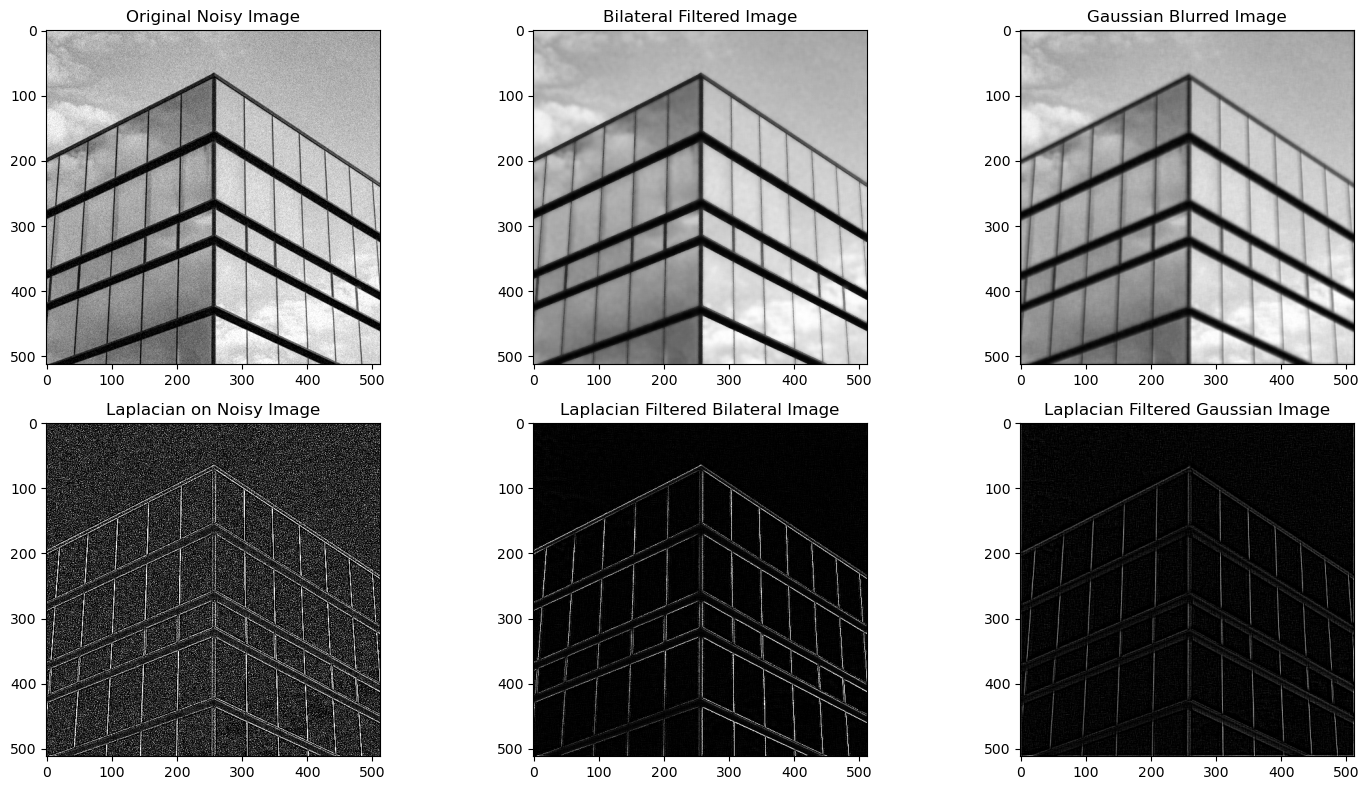

In [10]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1), plt.imshow(image, cmap='gray'), plt.title('Original Noisy Image')
plt.subplot(2, 3, 2), plt.imshow(bilateral_filtered_image, cmap='gray'), plt.title('Bilateral Filtered Image')
plt.subplot(2, 3, 3), plt.imshow(gaussian_blurred_image, cmap='gray'), plt.title('Gaussian Blurred Image')
plt.subplot(2, 3, 4), plt.imshow(laplacian_original, cmap='gray'), plt.title('Laplacian on Noisy Image')
plt.subplot(2, 3, 5), plt.imshow(laplacian_bilateral, cmap='gray'), plt.title('Laplacian Filtered Bilateral Image')
plt.subplot(2, 3, 6), plt.imshow(laplacian_gaussian, cmap='gray'), plt.title('Laplacian Filtered Gaussian Image')

plt.tight_layout()
plt.show()

# QUESTION - 2

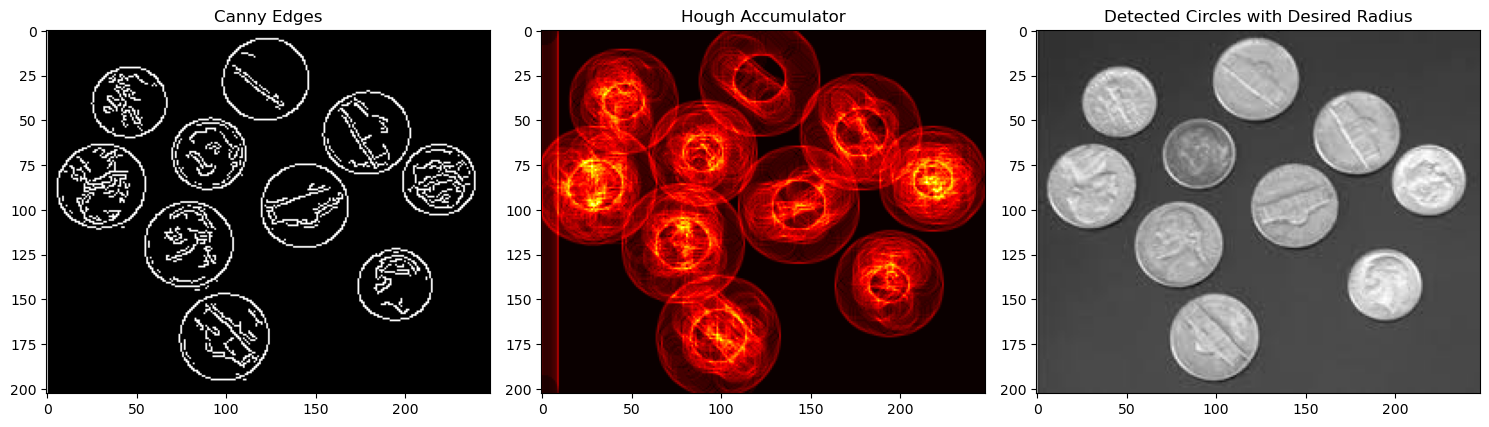

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'coins.png'  # Replace with your actual image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Parameters
radius = 10  # Desired radius for detecting circles
accumulator_threshold = 200  # Threshold for Hough accumulator

# Canny Edge Detection
edges_canny = cv2.Canny(image, 100, 200)

# Hough Transform for Circle Detection (with a fixed radius)
def hough_transform_circles(edges, radius, threshold):
    hough_accum = np.zeros_like(edges)
    y_idxs, x_idxs = np.nonzero(edges)
    
    for y, x in zip(y_idxs, x_idxs):
        for theta in np.arange(0, 360, 1):  # Iterate over all angles
            a = int(x - radius * np.cos(np.deg2rad(theta)))  # Calculate x-coordinate of circle center
            b = int(y - radius * np.sin(np.deg2rad(theta)))  # Calculate y-coordinate of circle center
            if 0 <= a < edges.shape[1] and 0 <= b < edges.shape[0]:
                hough_accum[b, a] += 1
    
    # Thresholding accumulator to get circle centers
    centers = np.argwhere(hough_accum >= threshold)
    return hough_accum, centers

# Apply Hough Transform (detect circles of specific radius)
accumulator_canny, centers_canny = hough_transform_circles(edges_canny, radius, accumulator_threshold)

# Plot Results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show Canny edges
axes[0].imshow(edges_canny, cmap='gray')
axes[0].set_title('Canny Edges')

# Show Hough accumulator
axes[1].imshow(accumulator_canny, cmap='hot')
axes[1].set_title('Hough Accumulator')

# Show detected circles on the original image
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for center in centers_canny:
    cv2.circle(output_image, (center[1], center[0]), radius, (0, 255, 0), 2)  # Draw circles on detected centers

axes[2].imshow(output_image)
axes[2].set_title('Detected Circles with Desired Radius')

plt.tight_layout()
plt.show()


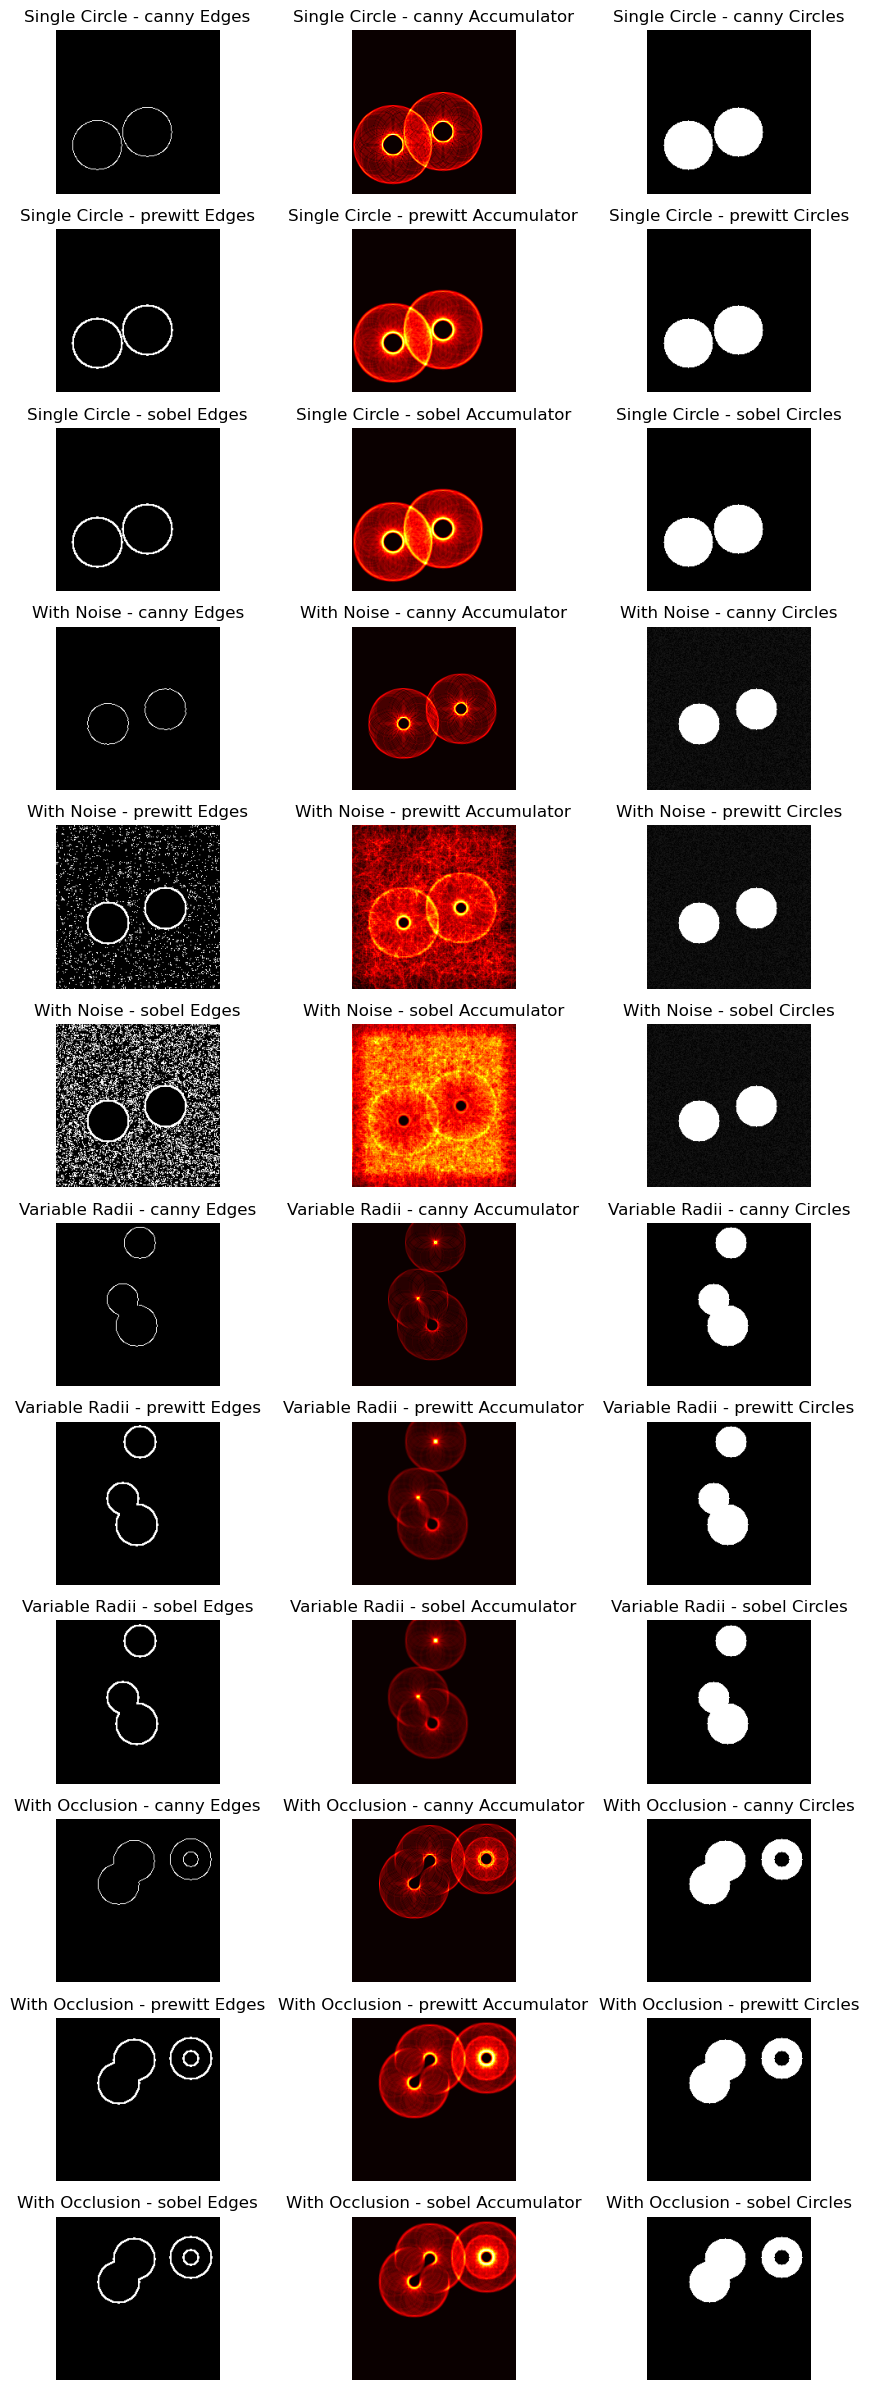

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def detect_edges(image, method='canny'):
    """Detects edges using Canny, Prewitt, or Sobel methods."""
    if method == 'canny':
        return cv2.Canny(image, 80, 180)
    elif method == 'prewitt':
        # Prewitt filter
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
        grad_x = cv2.filter2D(image, cv2.CV_64F, kernel_x)
        grad_y = cv2.filter2D(image, cv2.CV_64F, kernel_y)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        _, edges = cv2.threshold(magnitude, 40, 255, cv2.THRESH_BINARY)
        return edges
    elif method == 'sobel':
        # Sobel filter
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        _, edges = cv2.threshold(magnitude, 40, 255, cv2.THRESH_BINARY)
        return edges
    else:
        raise ValueError("Method must be 'canny', 'prewitt', or 'sobel'")

def circle_hough_transform(edges, radius=18, threshold=120):
    """Performs Hough Circle Transform with specified radius and threshold."""
    accumulator = np.zeros(edges.shape, dtype=np.uint64)
    theta = np.deg2rad(np.arange(360))
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    edge_points = np.argwhere(edges)

    for y, x in edge_points:
        a_vals = (x - radius * cos_theta).astype(int)
        b_vals = (y - radius * sin_theta).astype(int)
        valid_idx = (0 <= a_vals) & (a_vals < edges.shape[1]) & (0 <= b_vals) & (b_vals < edges.shape[0])
        accumulator[b_vals[valid_idx], a_vals[valid_idx]] += 1

    centers = np.argwhere(accumulator >= threshold)
    return centers, accumulator

def generate_circle_image(size=(200, 200), radius=15, num_circles=1, noise=0, varied_radius=False, occlude=False):
    """Generates an image with customizable circles, noise, and optional occlusion."""
    image = np.zeros(size, dtype=np.uint8)
    circles = [(random.randint(radius, size[1] - radius), random.randint(radius, size[0] - radius)) for _ in range(num_circles)]

    for x, y in circles:
        current_radius = radius if not varied_radius else random.randint(radius // 2, radius + radius // 2)
        cv2.circle(image, (x, y), current_radius, 255, thickness=-1)

    if noise > 0:
        noise_matrix = np.random.randint(0, 255 * noise, image.shape, dtype=np.uint8)
        image = cv2.add(image, noise_matrix)

    if occlude:
        for x, y in circles[: len(circles) // 2]:
            occlusion_radius = random.randint(4, 12)  # Adjust radius range as needed
            cv2.circle(image, (x, y), occlusion_radius, 0, -1)

    return image

# Test scenarios
scenarios = [
    ('Single Circle', generate_circle_image(radius=30, num_circles=2)),
    ('With Noise', generate_circle_image(radius=25, noise=0.1, num_circles=2)),
    ('Variable Radii', generate_circle_image(radius=25, num_circles=3, varied_radius=True)),
    ('With Occlusion', generate_circle_image(radius=25, num_circles=3, occlude=True))
]

methods = ['canny', 'prewitt', 'sobel']
fig, axs = plt.subplots(len(scenarios) * len(methods), 3, figsize=(10, 24))

row = 0
for scenario_name, image in scenarios:
    for method in methods:
        edges = detect_edges(image, method)
        centers, accumulator = circle_hough_transform(edges, radius=18, threshold=120)
        output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # Plot the detected circles
        for y, x in centers:
            cv2.circle(output_image, (x, y), 18, (0, 255, 0), 2)

        axs[row, 0].imshow(edges, cmap='gray')
        axs[row, 0].set_title(f'{scenario_name} - {method} Edges')
        axs[row, 0].axis('off')

        axs[row, 1].imshow(accumulator, cmap='hot')
        axs[row, 1].set_title(f'{scenario_name} - {method} Accumulator')
        axs[row, 1].axis('off')

        axs[row, 2].imshow(output_image)
        axs[row, 2].set_title(f'{scenario_name} - {method} Circles')
        axs[row, 2].axis('off')

        row += 1

plt.tight_layout()
plt.show()
